In [67]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

video = cv2.VideoCapture('red_car.mp4', cv2.CAP_AVFOUNDATION)

bbox = (835, 440, 125, 115) # template bounding box

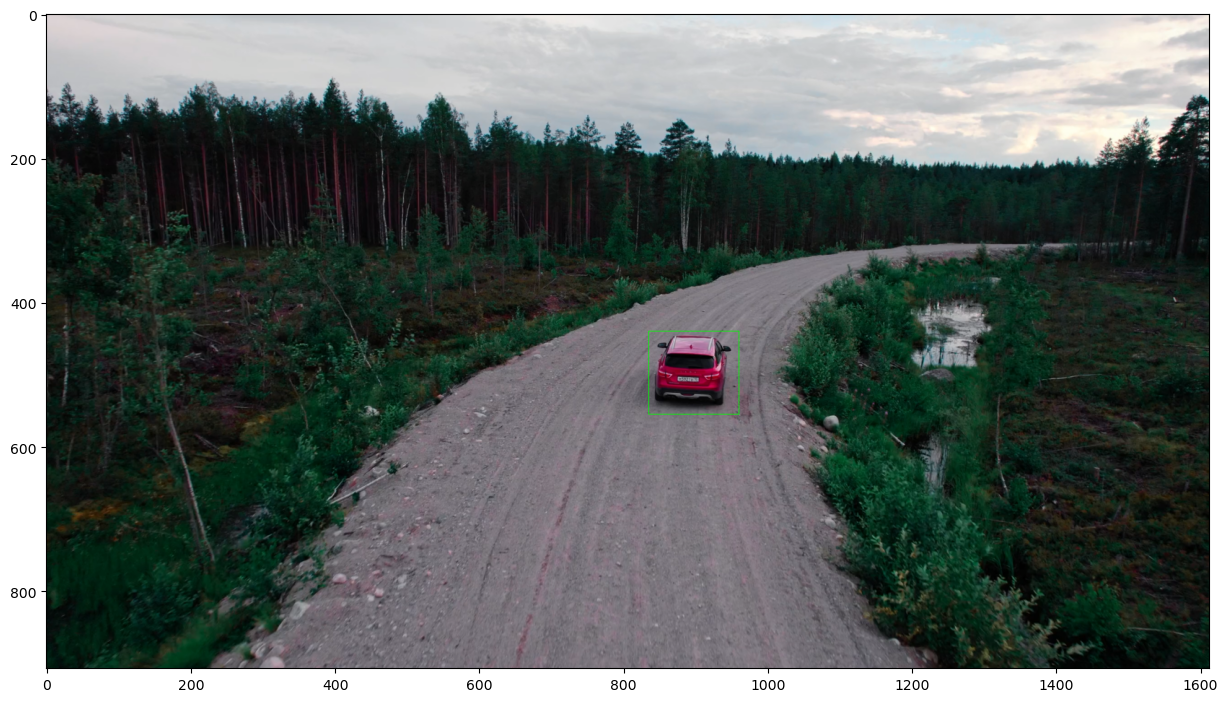

In [68]:
# downscale frame ot fasten computations
def downscale_frame(frame, scale=0.5):
    height, width = frame.shape[:2]
    new_dimensions = (int(width * scale), int(height * scale))
    return cv2.resize(frame, new_dimensions, interpolation=cv2.INTER_AREA)

# read the first frame
ok, frame = video.read()
if not ok:
    print("Failed to read video")
    video.release()
    exit()

scale_factor = 0.63 # selected by eye

downscaled_frame = downscale_frame(frame, scale=scale_factor)
downscaled_frame = cv2.cvtColor(downscaled_frame, cv2.COLOR_BGR2RGB)

# draw template bounding box
cv2.rectangle(downscaled_frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 1)
plt.imshow(downscaled_frame)

In [69]:
# initialize KCF tracker
kcf_tracker = cv2.TrackerKCF_create()
kcf_tracker.init(downscaled_frame, bbox)

# initialize CSRT tracker
csrt_tracker = cv2.TrackerCSRT_create()
csrt_tracker.init(downscaled_frame, bbox)

In [70]:
font = cv2.FONT_HERSHEY_SIMPLEX

# draw trackers' boun
def draw_bbox(frame, bbox, color, tracker_type, position, box_thickness, font_scale, font_thickness):
    x, y, w, h = [int(v) for v in bbox]
    cv2.rectangle(frame, (x, y), (x + w, y + h), color, box_thickness)
    cv2.putText(frame, f"{tracker_type} Tracker", position, font, font_scale, color, font_thickness)
    return frame

# Function to overlay one frame onto another with transparency
def overlay_frames(base_frame, overlay_frame, alpha=0.5):
    return cv2.addWeighted(overlay_frame, alpha, base_frame, 1 - alpha, 0)

# Function to draw the frame number in the middle of the frame
def draw_frame_number(frame, frame_number, font_scale, font_thickness):
    text = f"Frame: {frame_number}"
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = (frame.shape[1] - text_size[0]) // 2
    cv2.putText(frame, text, (text_x, 40), font, font_scale, (0, 0, 0), font_thickness)
    return frame

# track object using KCF and CSRT tracker for 15 frames. 
# I did both here because I wanted to combine results to see the differences better.
for frame_number in range(1, 16):
    ok, frame = video.read()
    if not ok:
        break
    downscaled_frame = downscale_frame(frame, scale=scale_factor)
    
    # update KCF tracker
    kcf_success, kcf_bbox = kcf_tracker.update(downscaled_frame)
    kcf_frame = downscaled_frame.copy()
    if kcf_success:
        kcf_frame = draw_bbox(kcf_frame, kcf_bbox, (0, 0, 255), "KCF", (20, 40), 2, 1, 3)
    else:
        cv2.putText(kcf_frame, "KCF Tracker failed", (20, 40), font, 1, (0, 0, 255), 3)
    
    # update CSRT tracker
    csrt_success, csrt_bbox = csrt_tracker.update(downscaled_frame)
    csrt_frame = downscaled_frame.copy()
    if csrt_success:
        csrt_frame = draw_bbox(csrt_frame, csrt_bbox, (255, 0, 0), "CSRT", (downscaled_frame.shape[1] - 250, 40), 2, 1, 3)
    else:
        cv2.putText(csrt_frame, "CSRT Tracker failed", (downscaled_frame.shape[1] - 200, 40), font, 1, (0, 0, 255), 3)
    
    # Make CSRT frame semitransparent
    overlay_frame = overlay_frames(kcf_frame, csrt_frame, alpha=0.3)

    # Draw frame number in the middle
    overlay_frame = draw_frame_number(overlay_frame, frame_number, 1, 3)

    # Save the combined frame
    cv2.imwrite(f"combined_frame_{frame_number}.jpg", overlay_frame)

video.release()

## Run tracking again with a "blurred" car

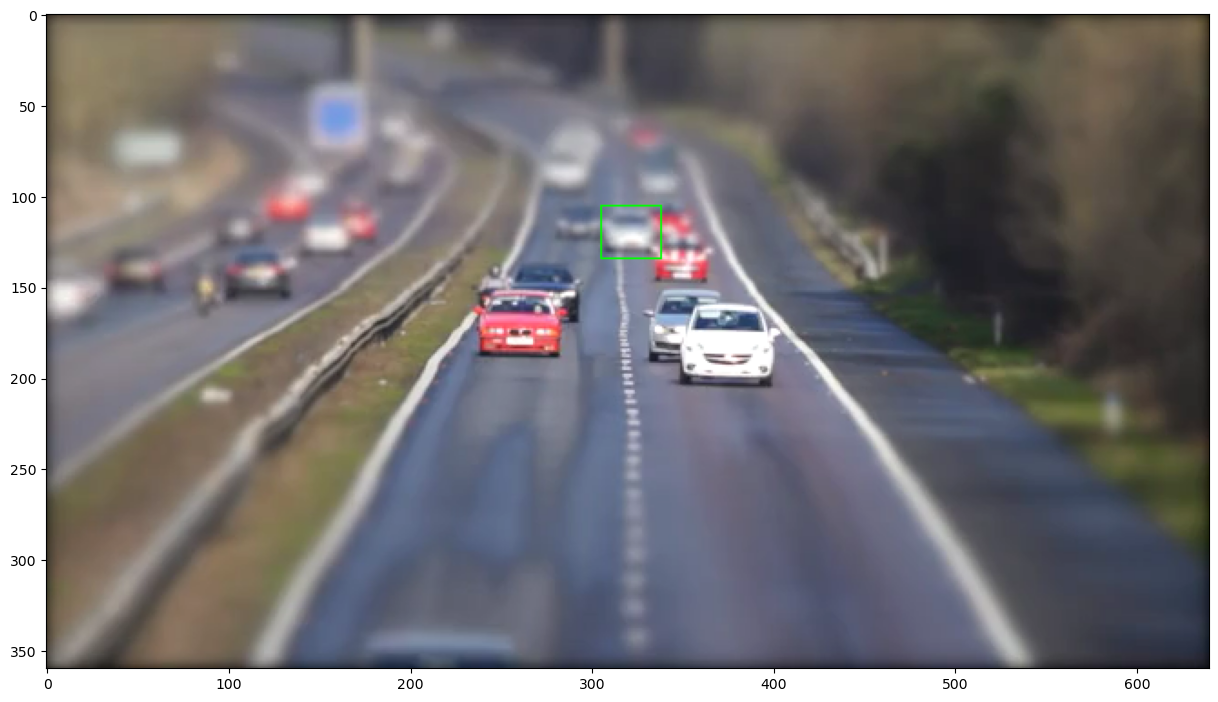

In [71]:
video = cv2.VideoCapture('cars.mp4', cv2.CAP_AVFOUNDATION)
# read the first frame
ok, frame = video.read()
if not ok:
    print("Failed to read video")
    video.release()
    exit()
    
bbox = (305, 105, 33, 29) # template bounding box
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 1)
plt.imshow(frame)

In [72]:
# initialize KCF tracker
kcf_tracker = cv2.TrackerKCF_create()
kcf_tracker.init(frame, bbox)

# initialize CSRT tracker
csrt_tracker = cv2.TrackerCSRT_create()
csrt_tracker.init(frame, bbox)

# track object using KCF and CSRT tracker for 15 frames. 
# I did both here because I wanted to combine results to see the differences better.
for frame_number in range(1, 16):
    ok, frame = video.read()
    if not ok:
        break
    
    # update KCF tracker
    kcf_success, kcf_bbox = kcf_tracker.update(frame)
    kcf_frame = frame.copy()
    if kcf_success:
        kcf_frame = draw_bbox(kcf_frame, kcf_bbox, (0, 0, 255), "KCF", (20, 40), 1, 0.7, 2)
    else:
        cv2.putText(kcf_frame, "KCF Tracker failed", (20, 40), font, 1, (0, 0, 255), 2)
    
    # update CSRT tracker
    csrt_success, csrt_bbox = csrt_tracker.update(frame)
    csrt_frame = frame.copy()
    if csrt_success:
        csrt_frame = draw_bbox(csrt_frame, csrt_bbox, (255, 0, 0), "CSRT", (frame.shape[1] - 160, 40), 1, 0.7, 2)
    else:
        cv2.putText(csrt_frame, "CSRT Tracker failed", (frame.shape[1] - 200, 40), font, 1, (0, 0, 255), 2)
    
    # Make CSRT frame semitransparent
    overlay_frame = overlay_frames(kcf_frame, csrt_frame, alpha=0.3)

    # Draw frame number in the middle
    overlay_frame = draw_frame_number(overlay_frame, frame_number, 0.7, 2)

    # Save the combined frame
    cv2.imwrite(f"cars_combined_frame_{frame_number}.jpg", overlay_frame)

video.release()

### With the red car the results are almost the same, CSRT slightly better.
### But with the next video with a blurred car CSRT performs better too, CSRT tracking bounding box contains the whole car with driver's rear mirror